## A Very Simple ``Dash`` App

In [48]:
from dash import Dash, html, Output, Input

app = Dash()

app.layout = html.Div([
    html.H1("A Simple App", id="title"),
    html.P("Structure things like you would in HTML"),
    html.Button("Click me to do something", id="button")
])

@app.callback(
    Output("title", "children"), # change this value
    Input("button", "n_clicks"), # when this changes
    prevent_initial_call = True
)
def update_title_on_buttonclick(n_clicks):
    print(n_clicks) # sure why not
    return "A Simple App **That Does Things!**"

#app.run()

## A Bit More Complicated App

Let's use bootstrap to spruce this up a bit

In [3]:
import dash_bootstrap_components as dbc

app = Dash(external_stylesheets=[dbc.themes.SKETCHY])

app.layout = html.Div([
    dbc.NavbarSimple(brand="Communities in Network Graphs"),
    dbc.Container([
        dbc.Row([
            dbc.Col(
                "Hello", width=3
            ),
            dbc.Col("Everyone", width=9)
        ])
    ])
])

#app.run()

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8050
Press CTRL+C to quit
127.0.0.1 - - [22/Apr/2023 21:22:24] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:22:25] "GET /_dash-component-suites/dash_bootstrap_components/_components/dash_bootstrap_components.v1_4_1m1682212359.min.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:22:26] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:22:26] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:22:26] "GET /_favicon.ico?v=2.9.2 HTTP/1.1" 200 -


## Cytoscape

Now we can use the `dash-cytoscape` package to display our graph. Let's start with wireframe layout and then add in the functionality we need:

Coercing column 'status' to `list`
Coercing column 'languages' to `list`


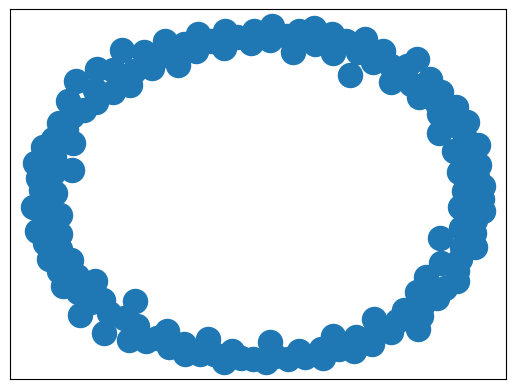

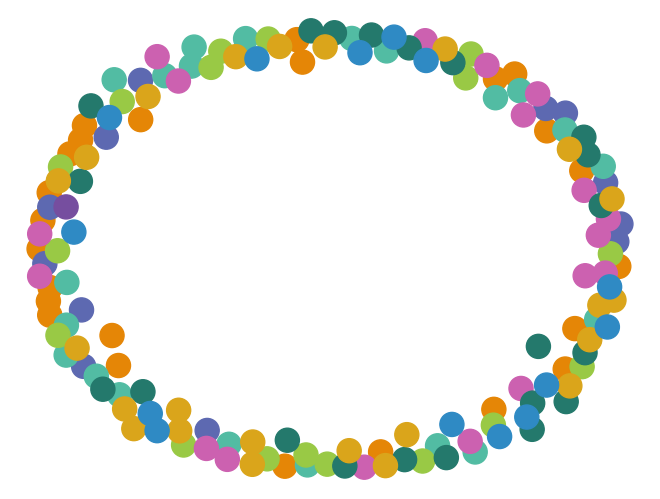

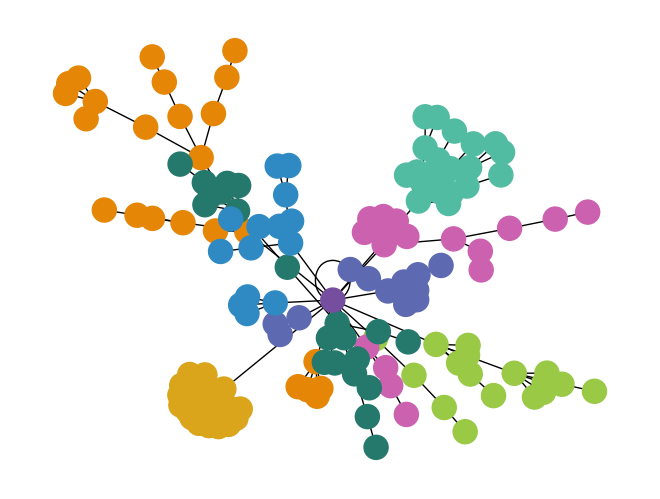

{'Kaitlyn Bennett': ['JavaScript'], 'Kaitlyn Wright': ['Python'], 'Bryan Wong': ['Java', 'Python'], 'Bradley Baxter': ['Typescript'], 'Christine Haynes': ['Java', 'JavaScript', 'Scala', 'Python'], 'Tracy Neal': ['Go'], 'Mark Schroeder': ['Typescript', 'JavaScript'], 'Shane Booker': ['Typescript', 'JavaScript', 'Java', 'Python'], 'Regina Rodriguez': ['Typescript', 'JavaScript', 'Python'], 'Jeff Thomas': ['Java', 'JavaScript', 'Go', 'Python'], 'Anthony Silva': ['JavaScript'], 'Samantha Walls': ['Java', 'JavaScript', 'Scala'], 'Karen Henry': ['Java', 'Python'], 'Debbie Howard': ['Typescript'], 'Lauren Riggs': ['Java', 'JavaScript', 'Python', 'Scala'], 'Vincent Cox': ['Python'], 'Miranda Smith': ['Java', 'JavaScript', 'Go', 'Typescript'], 'Cassandra Wallace': ['Typescript', 'Java', 'Python'], 'Lisa Reed': ['Typescript', 'Go', 'Java', 'Python'], 'Erica Johnson': ['Typescript'], 'Katherine Reynolds': ['Scala'], 'Richard Kelley': ['Go', 'Python'], 'Rachel Flynn': ['Java', 'JavaScript', 'Scala

In [40]:
%run "../Part 2 - Clustered Graph Attributes/Solution.ipynb"


In [41]:
def create_elements(attributes: list[str]=[]) -> list[dict]:
    """Generate a graph with connecting attributes and serialize it as cytoscape elements"""

In [42]:
elements = (
    nx.cytoscape_data(G)["elements"]["nodes"]
    + nx.cytoscape_data(G)["elements"]["edges"]
)

In [43]:
def stylesheet_(focus:str=CEO["name"], theme:str="light"):
    dark = theme == "dark"
    return [
    {
        "selector": "node",
        "style": {
            "font-size": 50,
            "color": "lightgrey" if dark else "darkgrey"
        }
    },
    {
        "selector": "edge",
        "style": {
            "line-color": "lightgrey" if dark else "darkgrey",
            "curve-style": "bezier",
            "label": "data(label)",
            "width": 1,
            "opacity": 0.25,
            "font-size": 10,
            "text-rotation": "autorotate",
        },
    },    
    {"selector": "edge[?languages]", "style": {"label": "codes"}},
    {"selector": "edge[?tz]", "style": {"label": "lives in"}},
    {"selector": "edge[?team]", "style": {"label": "belongs to"}},
    {"selector": "edge[?apps]", "style": {"label": "uses"}},
    {"selector": "edge[?manager]", "style": {"label": "manages", "source-arrow-shape":"triangle"}},     
    {
        "selector": "node[?person]",
        "style": {
            "label": "data(label)",
            "background-color": "lightgreen" if dark else "green",
            "width": 25,
            "height": 25,            
            "font-size": 16
        },
    },
    {
        "selector": "node[?language]",
        "style": {
            "label": "data(name)",
            "background-color": "white" if dark else "black",
            "width": 5,
            "height": 5,
        },
    },
    {
        "selector": "node[?timezone]",
        "style": {
            "label": "data(name)",
            "background-color": "white" if dark else "black",
            "width": 5,
            "height": 5,
        },
    },
    {
        "selector": f"node[id='{focus}']",
        "style":{
            "width": 25,
            "height": 25,
            "font-size": 20,
            "color":"skyblue",
            "background-color":"skyblue",
            "z-index":10            
        }
    },
    {
        "selector": "node[?app]",
        "style": {"label": "data(name)", "width": 5, "height": 5},
    },
]

In [47]:
from dash import dash, html, dcc, Input, Output

# from jupyter_dash import JupyterDash
import dash_cytoscape as cyto

# JupyterDash.infer_jupyter_proxy_config()
cyto.load_extra_layouts()
dashboard = dash.Dash(__name__)
# dashboard = JupyterDash(__name__)

cyto_layout = {
    "name": "cose",
    "idealEdgeLength": 100,
    "nodeOverlap": 20,
    "refresh": 20,
    "fit": True,
    "padding": 30,
    "randomize": False,
    "componentSpacing": 100,
    "nodeRepulsion": 400000,
    "edgeElasticity": 100,
    "nestingFactor": 5,
    "gravity": 80,
    "numIter": 1000,
    "initialTemp": 200,
    "coolingFactor": 0.95,
    "minTemp": 1.0,
    "nodeDimensionsIncludeLabels": True,
}


def layout():
    network = cyto.Cytoscape(
        id="network",
        layout=cyto_layout,
        responsive=True,
        style={"width": "100%", "height": "800px"},
        elements=elements,
        stylesheet=stylesheet_(),
    )
    return html.Div([html.H1("The Network"), network])


dashboard.layout = layout

if __name__ == "__main__":
    dashboard.run(port=16900, debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:16900/

 * Serving Flask app '__main__'
 * Debug mode: on


''

In [ ]:
app = dashboard.server

## Extras

* Change node size based on `rank` using a calculation
* Customize the layout
* Add a dropdown to choose how to colour nodes
    * Pick an attribute to color on people nodes like plotly
    * Color attribute nodes more statically